In [12]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
import warnings

# Load anats

In [102]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii"
atlas = ants.image_read(file)
atlas.set_spacing((0.65,0.65,1))

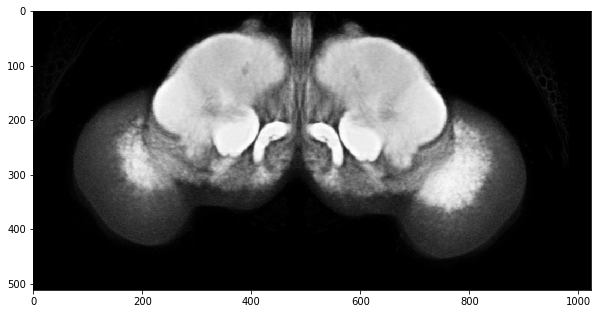

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(atlas[:,:,50].T,cmap='gray')

In [2]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(.76,.76,.76),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

In [3]:
FDA = FDA[:,:,::-1]
FDA_lowres = FDA_lowres[:,:,::-1]

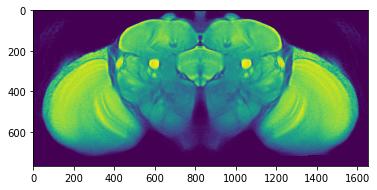

In [6]:
plt.imshow(FDA[:,:,200].T)

In [5]:
fly = 317#316
dir_ = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}'
file = os.path.join(dir_,'anat_0','moco','anatomy_channel_1_moc_mean.nii')
anat = ants.image_read(file)

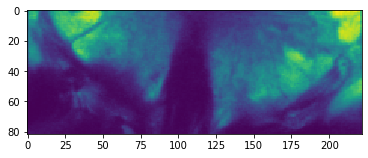

In [6]:
plt.imshow(anat[:,:,30].T)

In [7]:
anat.set_spacing((1.3,1.3,1))

In [8]:
anat_76 = ants.resample_image(anat,(.76,.76,.76),use_voxels=False)
ants.set_direction(anat_76,np.eye(3))

In [9]:
anat_76.shape

(380, 140, 93)

In [10]:
sub_dim = {'x':anat_76.shape[0],
           'y':anat_76.shape[1],
           'z':anat_76.shape[2]}
sub_mids = {'x': int(anat_76.shape[0]/2),
            'y': int(anat_76.shape[1]/2),
            'z': int(anat_76.shape[2]/2)}

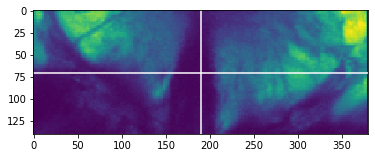

In [11]:
plt.imshow(anat_76[:,:,sub_mids['z']].T)
plt.axvline(sub_mids['x'],color='w')
plt.axhline(sub_mids['y'],color='w')

In [9]:
FDA_lowres.shape

(826, 384, 240)

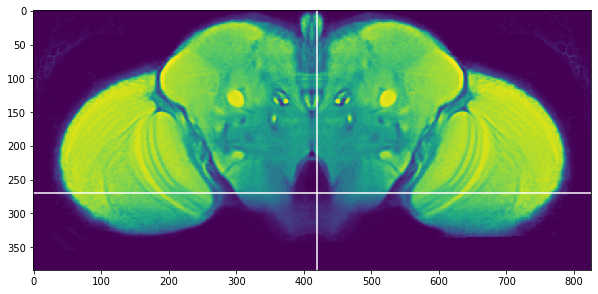

In [7]:
#center = {'x':400,'y':270,'z':110} #316
center = {'x':420,'y':270,'z':70} #317


plt.figure(figsize=(10,10))
plt.imshow(FDA_lowres[:,:,center['z']].T)
plt.axhline(center['y'],color='w')
plt.axvline(center['x'],color='w')

In [76]:
FDA_lowres_crop = FDA_lowres[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
                             center['y']-sub_mids['y']:center['y']+sub_mids['y'],
                             center['z']-sub_mids['z']:center['z']+sub_mids['z']]

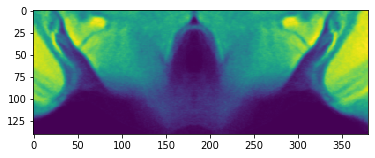

In [77]:
plt.imshow(FDA_lowres_crop[:,:,sub_mids['z']].T)

In [78]:
FDA_lowres_crop = ants.from_numpy(FDA_lowres_crop)
FDA_lowres_crop.set_spacing((0.76,0.76,0.76))

In [79]:
FDA_lowres.shape

(826, 384, 240)

# align

In [80]:
IPS_2_FDA = ants.registration(fixed = FDA_lowres_crop,
                  moving = anat_76,
                  type_of_transform = 'SyN')

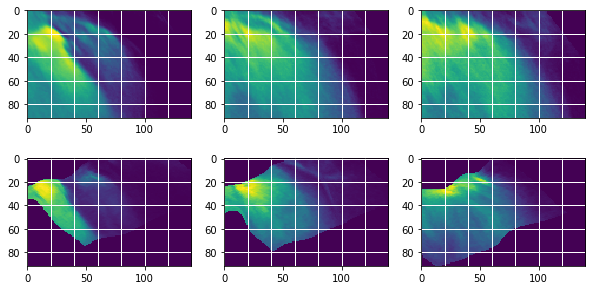

In [85]:
def draw_grid(vlines=7, hlines=5, step=20, lw=1):
    for i in np.arange(0,vlines*step,step):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*step,step):
        plt.axhline(i,color='w',lw=lw)
    
plt.figure(figsize=(10,5))
for i,k in enumerate([50,100,250]):
    plt.subplot(2,3,i+1)
    plt.imshow(FDA_lowres_crop.numpy()[k,:,:].T)
    draw_grid()
    plt.subplot(2,3,i+1+3)
    plt.imshow(IPS_2_FDA['warpedmovout'][k,:,:].T)
    draw_grid()

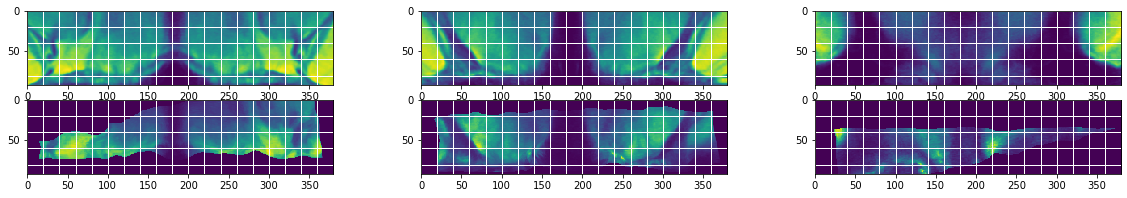

In [89]:
def draw_grid(vlines=19, hlines=5, step=20, lw=1):
    for i in np.arange(0,vlines*step,step):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*step,step):
        plt.axhline(i,color='w',lw=lw)

plt.figure(figsize=(20,3))
for i,k in enumerate([20,50,100]):
    plt.subplot(2,3,i+1)
    plt.imshow(FDA_lowres_crop.numpy()[:,k,::-1].T)
    draw_grid()
    plt.subplot(2,3,i+1+3)
    plt.imshow(IPS_2_FDA['warpedmovout'][:,k,::-1].T)
    draw_grid()

In [18]:
empty = np.zeros(FDA_lowres.shape)
empty[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
      center['y']-sub_mids['y']:center['y']+sub_mids['y'],
      center['z']-sub_mids['z']:center['z']+sub_mids['z']] = out['warpedmovout'].numpy()

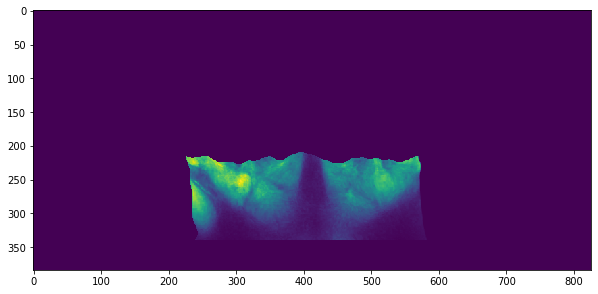

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(empty[:,:,center['z']].T)

# Load OG corrs

In [20]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [21]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [22]:
import bigbadbrain as bbb

In [23]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    print(1)
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    #r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res.shape

1
1
1


(314, 146, 91, 3)

In [29]:
OG_corr = []
for i in [0,1,2]:
    in_ = ants.from_numpy(maps_voxel_res.numpy()[:,:,:,i])
    OG_corr.append(ants.resample_image(in_,(826, 384, 240),use_voxels=True).numpy())
OG_corr = np.asarray(OG_corr)
OG_corr.shape

(3, 826, 384, 240)

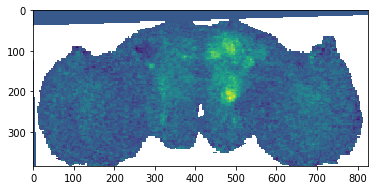

In [33]:
plt.imshow(OG_corr[0][:,:,100].T)

# Calculate corrs of IPS subvol

In [46]:
fly

316

In [65]:
os.listdir(f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/func_0/imaging')

['voltage_output.xml',
 'functional_channel_2_mean.nii',
 'bleaching.png',
 'functional.xml',
 'scan.json',
 'functional_channel_2.nii',
 'functional_channel_1_mean.nii',
 'timestamps.h5',
 'functional_channel_1.nii']

In [68]:
func = 'func_0'
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/imaging'
brain_file = os.path.join(load_directory, 'functional_channel_2.nii')
brain = ants.image_read(brain_file).numpy()
print(brain.shape)
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

(111, 41, 15, 13600)


In [50]:
# func = 'func_0'
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'
# brain_file = os.path.join(load_directory, 'functional_channel_2_moco_zscore.h5')
# with h5py.File(brain_file, 'r') as hf:
#     brain = hf['data'][:]
# print(brain.shape)
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

(111, 41, 15, 13600)


In [34]:
# func = 'func_0'
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/moco'
# brain_file = os.path.join(load_directory, 'functional_channel_2_moco.h5')
# with h5py.File(brain_file, 'r') as hf:
#     brain = hf['data'][:]
# print(brain.shape)
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

(111, 41, 15, 13600)


In [51]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))
fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))

Trying to load timestamp data from hdf5 file.
Success.


In [52]:
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY', 'dRotLabZ']
fictrac = {}
z=7
for behavior,short in zip(behaviors,['R','L','F','Turn']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

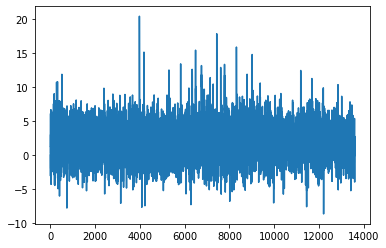

In [58]:
plt.plot(fictrac['F'])

In [53]:
dims = {'x':brain.shape[0],
        'y':brain.shape[1],
        'z':brain.shape[2],
        't':brain.shape[3]}

In [69]:
neural_activity = brain.reshape(-1, dims['t'])

In [70]:
neural_activity.shape

(68265, 13600)

In [71]:
corrs = {}
for behavior in ['R','L','F']:
    corrs_ = []
    for v in range(neural_activity.shape[0]):
        corr = scipy.stats.pearsonr(fictrac[behavior], neural_activity[v,:])[0]
        corrs_.append(corr)
    corrs_ = np.reshape(corrs_,(dims['x'],dims['y'],dims['z']))
    corrs[behavior] = corrs_

Text(0.5, 1.0, 'F, vmax=0.05')

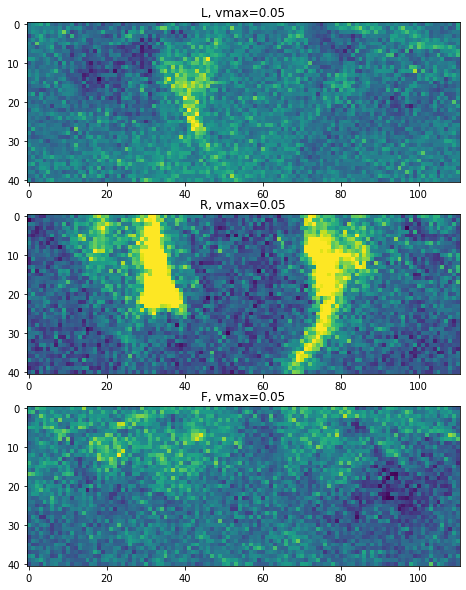

In [72]:
vmax = 0.05

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(np.max(corrs['L'],axis=2).T,vmax=vmax)
plt.title(F'L, vmax={vmax}')

plt.subplot(312)
plt.imshow(np.max(corrs['R'],axis=2).T,vmax=vmax)
plt.title(F'R, vmax={vmax}')

plt.subplot(313)
plt.imshow(np.max(corrs['F'],axis=2).T,vmax=vmax)
plt.title(F'F, vmax={vmax}')

# Warp IPS corr

In [109]:
corr_3var = np.concatenate((corrs['R'][...,np.newaxis],corrs['L'][...,np.newaxis],corrs['F'][...,np.newaxis]),axis=3)
corr_3var.shape

(111, 41, 15, 3)

In [110]:
corr_3var = ants.from_numpy(corr_3var)
corr_3var.set_spacing((2.6,2.6,5,1))

In [111]:
corr_3var = ants.resample_image(corr_3var,(380,140,93,3),use_voxels=True)
ants.set_direction(corr_3var,np.eye(4))

In [112]:
corr_3var

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (380, 140, 93, 3)
	 Spacing    : (0.7546, 0.7482, 0.7609, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [113]:
IPS_CORR_in_FDA = ants.apply_transforms(fixed = FDA_lowres_crop,
                                        moving = corr_3var,
                                        transformlist = IPS_2_FDA['fwdtransforms'],
                                        imagetype=3)

In [114]:
IPS_CORR_in_FDA

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (380, 140, 92, 3)
	 Spacing    : (0.76, 0.76, 0.76, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

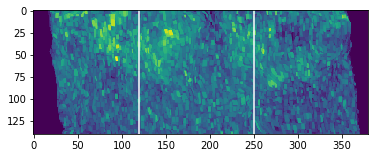

In [137]:
plt.imshow(np.max(IPS_CORR_in_FDA[:,:,:,2],axis=2).T)
plt.axvline(120,color='w')
plt.axvline(250,color='w')

# Crop to same area of FDA

In [138]:
beh = 2
OG_corr_crop = OG_corr[beh][center['x']-sub_mids['x']:center['x']+sub_mids['x'],
                             center['y']-sub_mids['y']:center['y']+sub_mids['y'],
                             center['z']-sub_mids['z']:center['z']+sub_mids['z']]

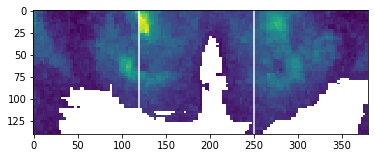

In [139]:
plt.imshow(np.max(OG_corr_crop,axis=2).T)
plt.axvline(120,color='w')
plt.axvline(250,color='w')